In [ ]:
# !pip install bert-for-tf2
# !wget https://storage.googleapis.com/bert_models/2019_05_30/wwm_uncased_L-24_H-1024_A-16.zip

In [1]:
%load_ext lab_black

# BERT embedding

### Create BERT model from file

In [2]:
from tensorflow import keras
import os, bert

model_dir = "embeddings/bert/uncased_L-12_H-768_A-12"
bert_params = bert.params_from_pretrained_ckpt(model_dir)
l_bert = bert.BertModelLayer.from_params(bert_params, name="bert")

max_seq_len = 8  # Since BERT also uses sublexical info (e.g., -s, -ed), for a single word 8 is enough for our corpus
l_input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32')

# using the default token_type
output = l_bert(l_input_ids, )  # output: [batch_size, max_seq_len, hidden_size]
model = keras.Model(inputs=l_input_ids, outputs=output)

# Build and load checkpoint weights
model.build(input_shape=(None, max_seq_len))
bert_ckpt_file = os.path.join(model_dir, "bert_model.ckpt")
bert.load_stock_weights(l_bert, bert_ckpt_file)

Done loading 196 BERT weights from: embeddings/bert/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7fbc43628438> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


[]

### Encode training set in BERT token id format

In [3]:
import pandas as pd
import numpy as np
from bert.tokenization.bert_tokenization import FullTokenizer
x_train = pd.read_csv(
    '/home/jupyter/tf/common/input/df_train.csv',
    na_filter=False  # since null in the corpus is not missing value
)
tokenizer = FullTokenizer(os.path.join(model_dir, "vocab.txt"))

x = np.zeros((len(x_train), max_seq_len))

for i, word in enumerate(x_train.word):
    tok = tokenizer.tokenize(word)
    tok = ["[CLS]"] + tok + [
        "[SEP]"
    ]  # [CLS] for marking beginning of sentence; [SEP] for marking the end of sentence (word)
    ids = tokenizer.convert_tokens_to_ids(tok)
    while len(ids) < max_seq_len:
        ids += [0]
    x[i, :] = ids

### Use BERT to create word embedding

In [4]:
y = model.predict(x)
y_max = np.amax(y, axis=1)
y_mean = np.mean(y, axis=1)

### Test with cosine similarity

In [5]:
test_cases = ['fire', 'heat', 'feet', 'war', 'girl', 'boy']

for case in test_cases:
    print(x_train.loc[x_train.word == case, 'word'])

1544    fire
Name: word, dtype: object
2209    heat
Name: word, dtype: object
1489    feet
Name: word, dtype: object
5534    war
Name: word, dtype: object
1888    girl
Name: word, dtype: object
391    boy
Name: word, dtype: object


In [6]:
from tensorflow.keras.losses import cosine_similarity


def check_sim():
    """
    A test case for checking the embedding is providing sensible similarity measure
    """

    print(
        'Cosine similarity range from -1 to 0, more negative indicate higher similarity'
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'fire', 'heat', cosine_similarity(fire, heat)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'fire', 'feet', cosine_similarity(fire, feet)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'feet', 'war', cosine_similarity(feet, war)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'feet', 'heat', cosine_similarity(feet, heat)
        )
    )

    print(
        'Similarity between {} and {} is {}'.format(
            'boy', 'girl', cosine_similarity(boy, girl)
        )
    )

### Check max pooling effectiveness by similarity

In [7]:
fire = y_max[1544]
heat = y_max[2209]
feet = y_max[1489]
war = y_max[5534]
girl = y_max[1888]
boy = y_max[391]

check_sim()

Cosine similarity range from -1 to 0, more negative indicate higher similarity
Similarity between fire and heat is -0.9841954112052917
Similarity between fire and feet is -0.9494524598121643
Similarity between feet and war is -0.9676526188850403
Similarity between feet and heat is -0.9520220160484314
Similarity between boy and girl is -0.9707289934158325


### Check mean pooling effectiveness by similarity

In [8]:
from tensorflow.keras.losses import cosine_similarity
fire = y_mean[1544]
heat = y_mean[2209]
feet = y_mean[1489]
war = y_mean[5534]
girl = y_mean[1888]
boy = y_mean[391]

check_sim()

Cosine similarity range from -1 to 0, more negative indicate higher similarity
Similarity between fire and heat is -0.9901940822601318
Similarity between fire and feet is -0.8547433614730835
Similarity between feet and war is -0.9534457325935364
Similarity between feet and heat is -0.858684778213501
Similarity between boy and girl is -0.9356228709220886


- Seems mean pooling works somewhat better than max pooling
- Some said 2nd to last layer is a better representation in similar type of model Bi-directional LSTM

### Export mean pooling BERT

In [11]:
np.savez_compressed('embeddings/bert/x_train_bert.npz', data=y_mean)

# Load and check
x = np.load('embeddings/x_train_bert.npz')['data']
print('Read test ok? {}'.format(np.all(x == y_mean)))

Read test ok? True


### What the embedding looks like in two pooling stregegy


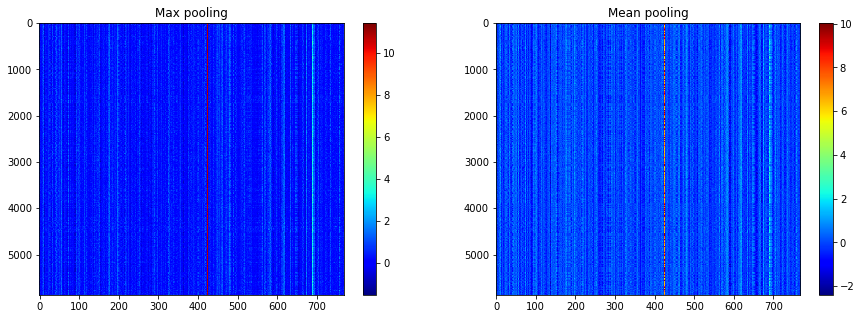

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Max pooling')
plt.imshow(y_max, cmap='jet', interpolation='nearest', aspect="auto")
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title('Mean pooling')
plt.imshow(y_mean, cmap='jet', interpolation='nearest', aspect="auto")
plt.colorbar()
plt.show()

- Somewhat more information in mean pooling...